In [0]:
from pyspark.sql.types import StructType, StructField, DateType, FloatType
from pyspark.sql.functions import to_date

#  Definisanje seme
cpi_schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Index", FloatType(), True)
])

# Ucitavanje podataka
cpi_data = spark.read.csv("dbfs:/FileStore/tables/cpi.csv",
                                schema=cpi_schema,
                                header=True)

# Konvertovanje datuma
cpi_data = cpi_data.withColumn("Date", to_date(cpi_data["Date"], "yyyy-MM-dd"))

cpi_data.show()

+----------+-------+
|      Date|  Index|
+----------+-------+
|2023-11-01|307.051|
|2023-10-01|307.671|
|2023-09-01|307.789|
|2023-08-01|307.026|
|2023-07-01|305.691|
|2023-06-01|305.109|
|2023-05-01|304.127|
|2023-04-01|303.363|
|2023-03-01|301.836|
|2023-02-01| 300.84|
|2023-01-01| 299.17|
|2022-12-01|296.797|
|2022-11-01|297.711|
|2022-10-01|298.012|
|2022-09-01|296.808|
|2022-08-01|296.171|
|2022-07-01|296.276|
|2022-06-01|296.311|
|2022-05-01|292.296|
|2022-04-01|289.109|
+----------+-------+
only showing top 20 rows



+-------+-----------------+
|summary|            Index|
+-------+-----------------+
|  count|             1331|
|   mean|87.09276039487521|
| stddev|85.14554360383217|
|    min|              9.7|
|    max|          307.789|
+-------+-----------------+



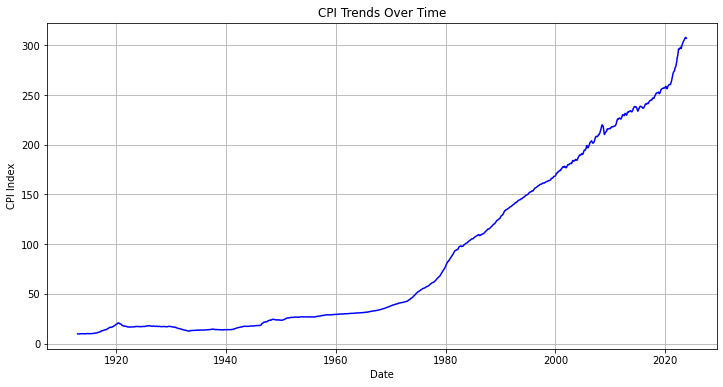

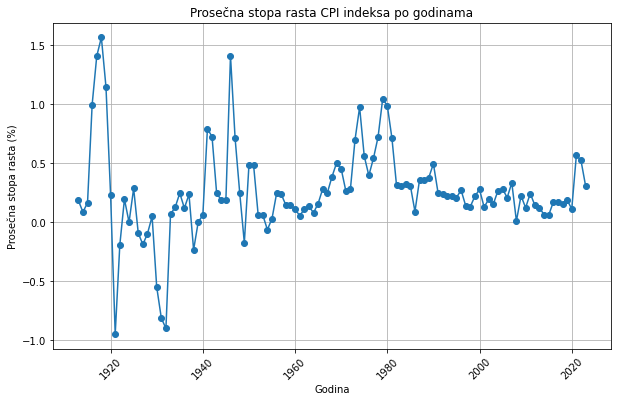

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import lag, col
from pyspark.sql import functions as F
# Descriptive Statistika
cpi_data.describe().show()

# Visualizacija
pd_cpi_data = cpi_data.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(pd_cpi_data['Date'], pd_cpi_data['Index'], color='blue')
plt.title('CPI Trends Over Time')
plt.xlabel('Date')
plt.ylabel('CPI Index')
plt.grid(True)
plt.show()




# Izračunavanje stope rasta
cpi_data = cpi_data.withColumn('GrowthRate', ((F.col('Index') - F.lag('Index', 1).over(Window.orderBy('Date'))) / F.lag('Index', 1).over(Window.orderBy('Date'))) * 100)

# Izračunavanje godine iz datuma i agregacija po godinama uz izračunavanje prosečne stope rasta
annual_growth_rate = (
    cpi_data
    .withColumn('Year', F.year('Date'))
    .groupBy('Year')
    .agg(F.avg('GrowthRate').alias('AvgGrowthRate'))
)

# Konvertiranje rezultata u Pandas DataFrame radi vizualizacije
pd_annual_growth_rate = annual_growth_rate.toPandas()

# Vizualizacija prosečne stope rasta po godinama
plt.figure(figsize=(10, 6))
plt.plot(pd_annual_growth_rate['Year'], pd_annual_growth_rate['AvgGrowthRate'], marker='o', linestyle='-')
plt.title('Prosečna stopa rasta CPI indeksa po godinama')
plt.xlabel('Godina')
plt.ylabel('Prosečna stopa rasta (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotiranje oznaka x-osi radi bolje čitljivosti godina
plt.show()



In [0]:
#Zakljucujem da posle drugog svetskog rata postoje manje oscilacije u odnosu na period pre
from pyspark.sql.types import StructType, StructField, DateType, FloatType
from pyspark.sql.functions import to_date

# definisanje seme
unemployment_schema = StructType([
    StructField("Date", DateType(), True),
    StructField("UnemploymentRate", FloatType(), True)
])

# Ucitavanje podataka
unemployment_data = spark.read.csv("dbfs:/FileStore/tables/unemploymentRate.csv",
                                   schema=unemployment_schema,
                                   header=True)

# Konvertovanje datuma
unemployment_data = unemployment_data.withColumn("Date", to_date(unemployment_data["Date"], "yyyy-MM-dd"))

unemployment_data.show()


+----------+----------------+
|      Date|UnemploymentRate|
+----------+----------------+
|2023-12-01|             3.7|
|2023-11-01|             3.7|
|2023-10-01|             3.8|
|2023-09-01|             3.8|
|2023-08-01|             3.8|
|2023-07-01|             3.5|
|2023-06-01|             3.6|
|2023-05-01|             3.7|
|2023-04-01|             3.4|
|2023-03-01|             3.5|
|2023-02-01|             3.6|
|2023-01-01|             3.4|
|2022-12-01|             3.5|
|2022-11-01|             3.6|
|2022-10-01|             3.6|
|2022-09-01|             3.5|
|2022-08-01|             3.6|
|2022-07-01|             3.5|
|2022-06-01|             3.6|
|2022-05-01|             3.6|
+----------+----------------+
only showing top 20 rows



+-------+------------------+
|summary|  UnemploymentRate|
+-------+------------------+
|  count|               912|
|   mean|   5.7047149091959|
| stddev|1.7098056910160406|
|    min|               2.5|
|    max|              14.8|
+-------+------------------+



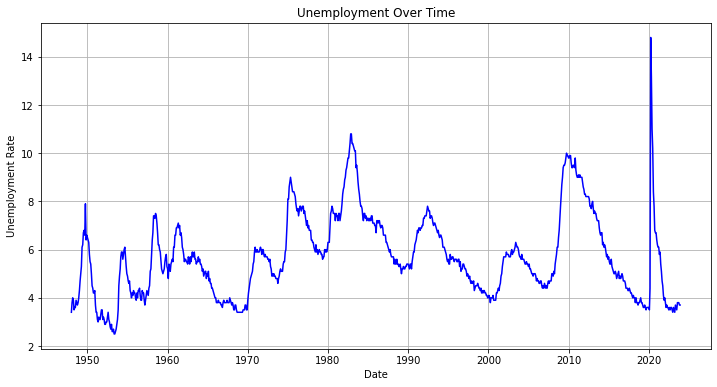

In [0]:
# Descriptivna statistika
unemployment_data.describe().show()

# Visualizacija
pd_unemploymentData = unemployment_data.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(pd_unemploymentData['Date'], pd_unemploymentData['UnemploymentRate'], color='blue')
plt.title('Unemployment Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.show()

In [0]:
# Spajanje podataka 
joined_data = cpi_data.join(unemployment_data, "Date")

# Izračunavanje Pearsonovog koeficijenta korelacije između  "Index" (CPI) i "UnemploymentRate" (stopa nezaposlenosti)
correlation = joined_data.corr("Index", "UnemploymentRate", method="pearson")

print("Pearsonov koeficijent korelacije između CPI i stope nezaposlenosti:", correlation)


Pearsonov koeficijent korelacije između CPI i stope nezaposlenosti: 0.11637029894795434


Mean Squared Error: 1134.345300075938
R-squared: 0.846433475174387


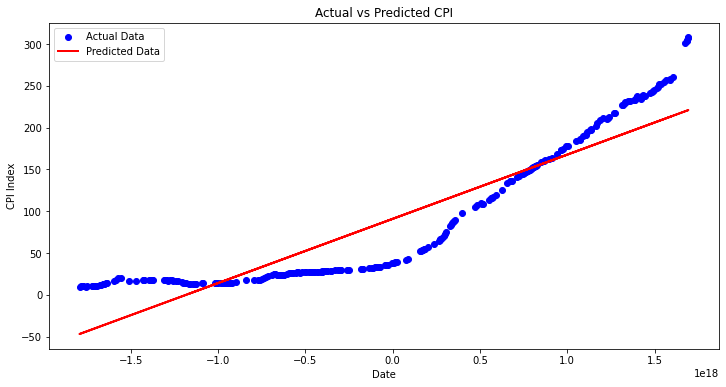

In [0]:
# Nema smisla raditi predikciju na osnovu unemployment rejta kada je koeficijent korelacije blizu nule.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Konverzija Spark DataFrame-a u Pandas DataFrame
cpi_data_pd = cpi_data.toPandas()

# Uklanjanje Nedostajućih Vrednosti
cpi_data_pd.dropna(inplace=True)

# posto imam samo datum po datumima cemo i raditi
X = pd.to_numeric(pd.to_datetime(cpi_data_pd['Date'])).values.reshape(-1, 1)
y = cpi_data_pd['Index']

# Podjela podataka na skupove za obuku i testiranje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Obučavanje Linearnog Regresijskog Modela
model = LinearRegression()
model.fit(X_train, y_train)

# Testiranje koliko dobro će model predvidjeti vrednosti CPI
y_pred = model.predict(X_test)

# Provera rezultata
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Ispis rezultata
print("Mean Squared Error:", mse)
print("R-squared:", r2)
# Plotovanje stvarnih i predviđenih vrijednosti
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Data')

plt.title('Actual vs Predicted CPI')
plt.xlabel('Date')
plt.ylabel('CPI Index')
plt.legend()
plt.show()

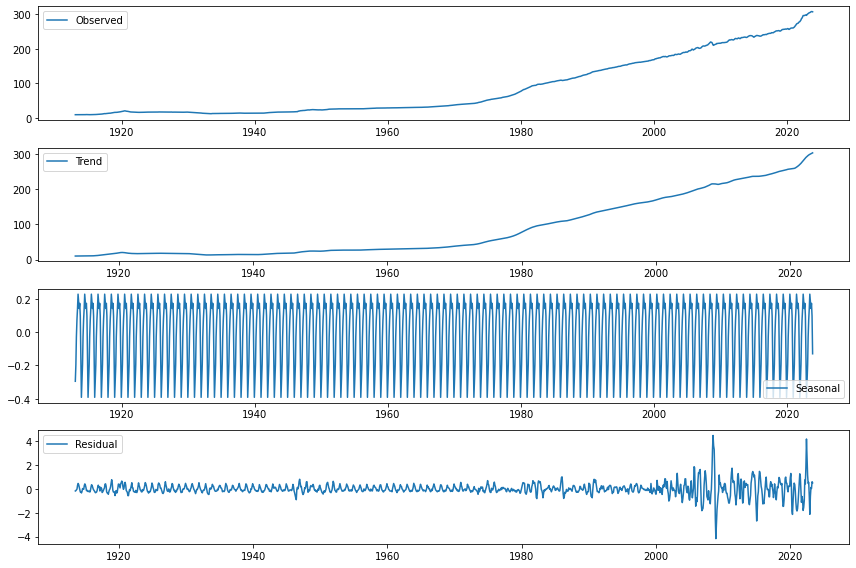

In [0]:
# Posto nam je r Squared 0.83 to znaci da je prediktivna moc dobra s obizrom da imamo samo jednu vrednost na osnovu koje vrsimo predikciju, ali ima prostora za unapredjenje modela.
from statsmodels.tsa.seasonal import seasonal_decompose

# Konvertujte DataFrame u Pandas DataFrame
pd_cpi_data = cpi_data.toPandas()

# Izvršite sezonsku dekompoziciju
result = seasonal_decompose(pd_cpi_data['Index'], model='additive', period=12)

# Vizualizirajte rezultate dekompozicije
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(pd_cpi_data['Date'], result.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(pd_cpi_data['Date'], result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(pd_cpi_data['Date'], result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(pd_cpi_data['Date'], result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()



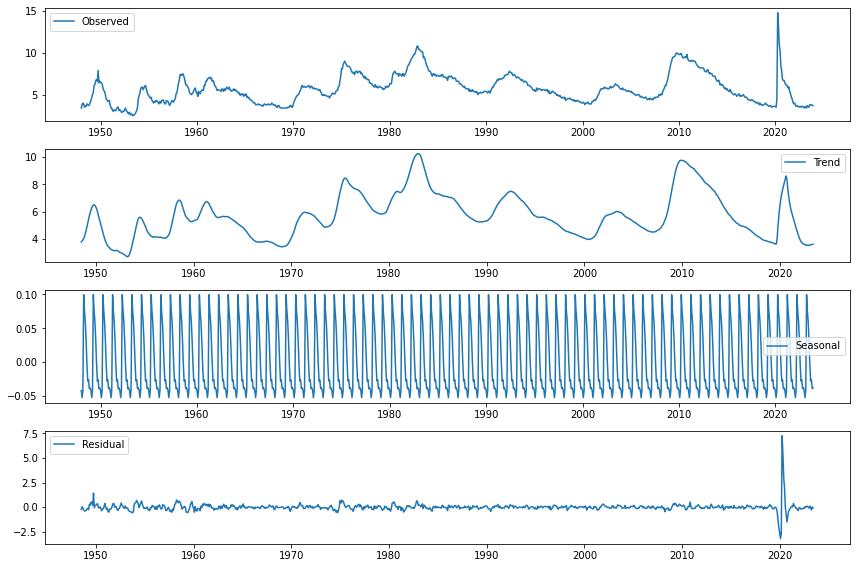

In [0]:
# Izvršite sezonsku dekompoziciju
result_unemployment = seasonal_decompose(pd_unemploymentData['UnemploymentRate'], model='additive', period=12)

# Vizualizacija rezultata dekompozicije
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(pd_unemploymentData['Date'], result_unemployment.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(pd_unemploymentData['Date'], result_unemployment.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(pd_unemploymentData['Date'], result_unemployment.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(pd_unemploymentData['Date'], result_unemployment.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [0]:
# Posto su i u jednoj i u drugoj dekompoziciji prva dva grafa slicna, to znaci da da podaci prate prilično konstantan i linearan trend tokom vremena. Konstantne oštre cik-cak oscilacije na sezonskom grafikonu sugerisu na to da postoje redovni ciklusi ili sezonske promene u nezaposlenosti koje se ponavljaju svakog perioda ali ovo cu proveriti preko stacionarnosti. Na primer primeticemo da se nezaposlenost povećava svakog leta kada se završe studentski poslovi ili se smanjuje kada se povećava potražnja za radnicima tokom praznične sezone. Rezidualna komponenta predstavlja neobjašnjenu varijabilnost ili šum u podacima nakon što su uklonjeni trend i sezonske varijacije. Primeticemo da u 2020 imamo imamo neobjasnjenost -korona a ostatak posto je poprilicno linearan znaci da je sve vec objasnjeno preko stalih grafova i da nema nekih neobjasnjenih stvari.

from statsmodels.tsa.stattools import adfuller

# Primena Augmented Dickey-Fuller Testa
result = adfuller(pd_unemploymentData['UnemploymentRate'])
print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")


#Zakljucak je da ne postoje trendovi i seezonski ciklusi kao ni neobjasnjive promene.

ADF Statistic: -3.866993
p-value: 0.002292
Series is stationary
